In [1]:
from pathlib import Path
import numpy as np
import os
SEED = 5
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)

import tensorflow as tf
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore", category=FutureWarning)

def reset_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

reset_seeds(SEED)

2025-05-19 17:19:56.552714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747667996.563354   16413 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747667996.566532   16413 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747667996.575237   16413 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747667996.575248   16413 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747667996.575249   16413 computation_placer.cc:177] computation placer alr

In [2]:
datasets = Path('datasets')

data_labels = {}

for i, dir in enumerate(datasets.iterdir()):
    data_labels[dir.name] = i

data_labels

{'Fridges and freezers': 0,
 'Televisions (LCD or LED)': 1,
 'Microwave ovens': 2,
 'Hi-Fi systems (with CD players)': 3,
 'Computers stations (with monitors)': 4,
 'Coffee machines': 5,
 'Laptops (via chargers)': 6,
 'Mobile phones (via chargers)': 7,
 'Lamps (compact fluorescent)': 8,
 'Printers': 9}

In [3]:
colnames = ['phAngle', 'freq', 'reacPower', 'power', 'rmsVolt', 'rmsCur']

data = []
labels = []

for dir in datasets.iterdir():
    label = datasets / dir.name

    for file in label.iterdir():
        
        with open(file, 'r') as f:
            file_content = f.readlines()
        
        file_content = [line[1:-2] for line in file_content if line[0] != '#']
        columns = np.array([list(map(float, row.split(' '))) for row in file_content])
        padded = tf.keras.preprocessing.sequence.pad_sequences(columns, maxlen=360, dtype='float32', padding='pre').T

        data.append(padded)
        labels.append(data_labels[file.parent.name])

data, labels = np.array(data), np.array(labels)

data.shape, labels.shape

((200, 360, 6), (200,))

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin


class Reshape3DTo2D(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(-1, 6)
    

class Reshape2DTo3D(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(-1, 360, 6)

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


preprocess = Pipeline([
    ('to2D', Reshape3DTo2D()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('to3D', Reshape2DTo3D())
])

preprocess

Pipeline(steps=[('to2D', Reshape3DTo2D()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()), ('to3D', Reshape2DTo3D())])

In [6]:
from sklearn.model_selection import train_test_split


X_train, X_validate, Y_train, Y_validate = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=SEED)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_validate, Y_validate, test_size=0.33, stratify=Y_validate, random_state=SEED)

X_train.shape

(140, 360, 6)

In [7]:
# Augmentation new data with noise
X_train_aug = []
Y_train_aug = []

for i, arr in enumerate(X_train):
    for j in range(2):
        if j == 0: np.random.seed(SEED)
        else: np.random.seed(SEED+1)
        X_train_aug.append(arr + np.random.normal(0, 0.001, size=arr.shape))
        Y_train_aug.append(Y_train[i])

X_train_aug = np.array(X_train_aug)
Y_train_aug = np.array(Y_train_aug)

X_train = np.concatenate([X_train, X_train_aug], axis=0)
Y_train = np.concatenate([Y_train, Y_train_aug], axis=0)

X_train.shape

(420, 360, 6)

In [ ]:
reset_seeds(SEED)

def make_model():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(360, 6)),
        tf.keras.layers.GRU(units=256, return_sequences=True, reset_after=True),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(units=10, activation='softmax'),
    ])

model = make_model()
model.load_weights('started.weights.h5')

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Nadam(),
              metrics=['accuracy']
)

model.summary()

mc1 = tf.keras.callbacks.ModelCheckpoint('best_model_1.keras', monitor='val_accuracy', mode='max', save_best_only=True)
mc2 = tf.keras.callbacks.ModelCheckpoint('best_model_2.keras', monitor='val_loss', mode='min', save_best_only=True)

preprocess.fit(X_train)
history = model.fit(
    preprocess.transform(X_train),
    tf.keras.utils.to_categorical(Y_train),
    validation_data=(preprocess.transform(X_validate), tf.keras.utils.to_categorical(Y_validate)),
    batch_size=8,
    epochs=100,
    callbacks=[mc1, mc2],
)

I0000 00:00:1747667998.858967   16413 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 360, 256)       │       202,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,322 (802.04 KB)

 Trainable params: 205,322 (802.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2025-05-19 17:19:59.775115: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1747668000.760604   16484 cuda_dnn.cc:529] Loaded cuDNN version 90300


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.1558 - loss: 2.2439 - val_accuracy: 0.4750 - val_loss: 1.7756
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2925 - loss: 1.7696 - val_accuracy: 0.4250 - val_loss: 1.5989
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4198 - loss: 1.4734 - val_accuracy: 0.5000 - val_loss: 1.4329
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4821 - loss: 1.4019 - val_accuracy: 0.5250 - val_loss: 1.3703
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4813 - loss: 1.2962 - val_accuracy: 0.6000 - val_loss: 1.2392
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5254 - loss: 1.1750 - val_accuracy: 0.5500 - val_loss: 1.1752
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5602 - loss: 1.1073 - val_accuracy: 0.6250 - val_loss: 1.0795
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6231 - loss: 1.0013 - val_accuracy: 0.7250 - val_l

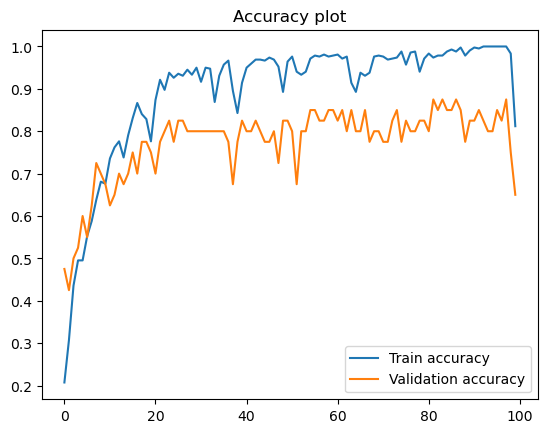

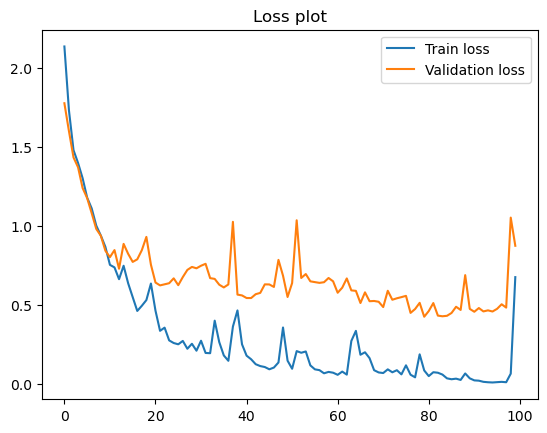

In [9]:
plt.plot(history.epoch, history.history['accuracy'], label='Train accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy plot')
plt.show()

plt.plot(history.epoch, history.history['loss'], label='Train loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss plot')
plt.show()

Test accuracy: 0.85
Test recall: 0.85
Test precision: 0.9
Test f1: 0.8533333333333333


2025-05-19 17:22:24.209590: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


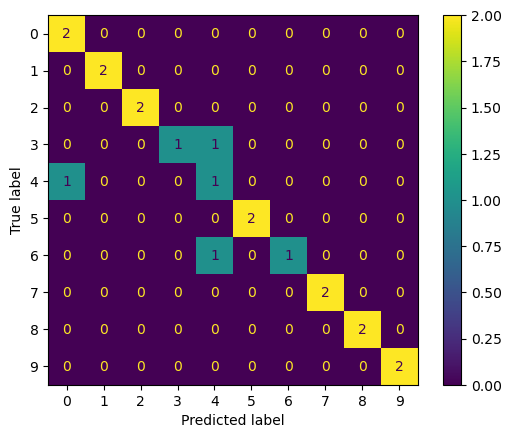

In [10]:
model = tf.keras.models.load_model('best_model_1.keras')

preds = np.argmax(model.predict(preprocess.transform(X_test), verbose=0), axis=1)

results = pd.DataFrame({
    'preds': preds,
    'true': Y_test
})

print(f'Test accuracy: {accuracy_score(results['true'], results['preds'])}')
print(f'Test recall: {recall_score(results['true'], results['preds'], average='weighted')}')
print(f'Test precision: {precision_score(results['true'], results['preds'], average='weighted')}')
print(f'Test f1: {f1_score(results['true'], results['preds'], average='weighted')}')

cm = confusion_matrix(results['true'], results['preds'])
ConfusionMatrixDisplay(cm).plot()

Full dataset accuracy: 0.95
Full dataset recall: 0.95
Full dataset precision: 0.9565993788819875
Full dataset f1: 0.9507462143713151


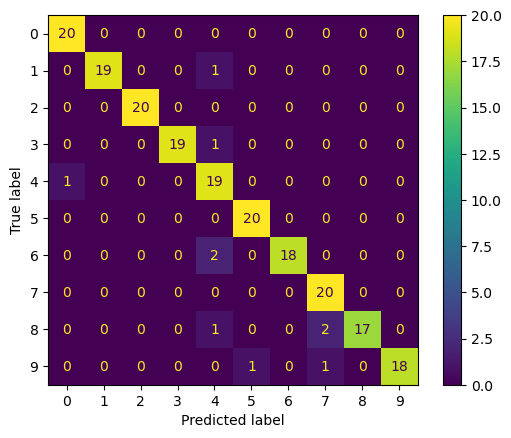

In [11]:
preds = np.argmax(model.predict(preprocess.transform(data), verbose=0), axis=1)

results = pd.DataFrame({
    'preds': preds,
    'true': labels
})

print(f'Full dataset accuracy: {accuracy_score(results['true'], results['preds'])}')
print(f'Full dataset recall: {recall_score(results['true'], results['preds'], average='weighted')}')
print(f'Full dataset precision: {precision_score(results['true'], results['preds'], average='weighted')}')
print(f'Full dataset f1: {f1_score(results['true'], results['preds'], average='weighted')}')

cm = confusion_matrix(results['true'], results['preds'])
ConfusionMatrixDisplay(cm).plot()

# Crossvalidation

In [ ]:
reset_seeds(SEED)

accuracies = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for train_index, test_index in skf.split(data, labels):
    
    X_train_fold, X_test = data[train_index], data[test_index]
    Y_train_fold, Y_test = labels[train_index], labels[test_index]

    X_train_aug = []
    Y_train_aug = []

    for i, arr in enumerate(X_train_fold):
        for j in range(1):
            np.random.seed(SEED+j)
            X_train_aug.append(arr + np.random.normal(0, 0.001, size=arr.shape))
            Y_train_aug.append(Y_train_fold[i])
        
    reset_seeds(SEED)

    X_train_aug = np.array(X_train_aug)
    Y_train_aug = np.array(Y_train_aug)

    X_train_fold = np.concatenate([X_train_fold, X_train_aug], axis=0)
    Y_train_fold = np.concatenate([Y_train_fold, Y_train_aug], axis=0)

    print(X_train_fold.shape)

    model = make_model()
    model.load_weights('started.weights.h5')

    model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Nadam(),
                metrics=['accuracy']
    )

    mc = tf.keras.callbacks.ModelCheckpoint('best_model_folds.keras', monitor='val_loss', mode='min', save_best_only=True)

    preprocess.fit(X_train)
    history = model.fit(
        preprocess.transform(X_train_fold),
        tf.keras.utils.to_categorical(Y_train_fold),
        batch_size=8,
        epochs=100,
        verbose=0,
        callbacks=[mc],
        validation_split=0.2
    )

    model = tf.keras.models.load_model('best_model_folds.keras')

    preds = np.argmax(model.predict(preprocess.transform(X_test), verbose=0), axis=1)

    acc = accuracy_score(Y_test, preds)
    accuracies.append(acc)

    print(f'Test accuracy: {acc}')
    print(f'Test recall: {recall_score(Y_test, preds, average='weighted')}')
    print(f'Test precision: {precision_score(Y_test, preds, average='weighted')}')
    print(f'Test f1: {f1_score(Y_test, preds, average='weighted')}')

    cm = confusion_matrix(Y_test, preds)
    print(cm)
    print()
    

print(f'Mean test accuracy: {np.mean(accuracies)}')

(320, 360, 6)
